In [1]:
# CHECK PYTHON VERSION

import sys

print("Python version")
print(sys.version)

Python version
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [0]:
# IMPORTING LIBRARIES

from __future__ import division
from __future__ import print_function

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy import sparse
from operator import itemgetter


import networkx as nx         # for reading edgelist and extracting other graph properties.

In [0]:
# FOR REPRODUCIBILITY
# Set random seed
seed = 123
np.random.seed(seed)

### **Utility Functions**

In [0]:
def load_data():
    # READ EDGELIST DATASET & CONVERT IT TO MATRIX
    g = nx.read_edgelist('/content/drive/My Drive/Dataset-Yeast/yeast.edgelist')
    adj = nx.adjacency_matrix(g)
    return adj


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


def mask_test_edges(adj):
    # Function to build test set with 2% positive links
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    # Take the upper triangle of elimanted digonal Adj matrix.
    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu) # Finad all the non-zero index in matrix(undirected matrix)
    edges = adj_tuple[0] # edge index list
    edges_all = sparse_to_tuple(adj)[0]   # Finad all the non-zero index in matrix Adj(no digonal directed matrix) 
    num_test = int(np.floor(edges.shape[0] / 50.)) # number of edges for test
    num_val = int(np.floor(edges.shape[0] / 50.)) # number of edges for val
    # num_test = int(np.floor(edges.shape[0] / 4.))
    # num_val = int(np.floor(edges.shape[0] / 4.))


    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b):
        rows_close = np.all((a - b[:, None]) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        n_rnd = len(test_edges) - len(test_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], edges_all):
                continue
            if test_edges_false:
                if ismember([idx_j, idx_i], np.array(test_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(test_edges_false)):
                    continue
            test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        n_rnd = len(val_edges) - len(val_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], train_edges):
                continue
            if ismember([idx_j, idx_i], train_edges):
                continue
            if ismember([idx_i, idx_j], val_edges):
                continue
            if ismember([idx_j, idx_i], val_edges):
                continue
            if val_edges_false:
                if ismember([idx_j, idx_i], np.array(val_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(val_edges_false)):
                    continue
            val_edges_false.append([idx_i, idx_j])

    # Re-build adj matrix
    data = np.ones(train_edges.shape[0])
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false


### Reading dataset

In [5]:
adj = load_data()
print("Type of Adj matrix : ",type(adj))
print("Shape of Adj matrix: ",adj.shape)

num_nodes = adj.shape[0]
num_edges = adj.sum()
print("Num of Nodes      : ",num_nodes)
print("Sum of all weights: ",num_edges)

Type of Adj matrix :  <class 'scipy.sparse.csr.csr_matrix'>
Shape of Adj matrix:  (6526, 6526)
Num of Nodes      :  6526
Sum of all weights:  1062675


In [0]:
# EXTRACING THE PROTEIN NAMES IN A LIST

g = nx.read_edgelist('/content/drive/My Drive/Dataset-Yeast/yeast.edgelist') # read ppi edgelist
protien_node_list = list(g.nodes()) 

### **Calculating Highly Centralized Proteins**

---
**Degree Centrality:** After getting some basic measures of the entire network structure, a good next step is to find which nodes are the most important ones in your network. In network analysis, measures of the importance of nodes are referred to as centrality measures. Degree centrality produce dictionaries in which the keys are nodes and the values are centrality measures. 
Degree can tell you about the biggest hubs, but it can’t tell you that much about the rest of the nodes.

In [7]:
#degree_centrality: The degree centrality for a node v is the fraction of nodes it is connected to.
degree_centrality = nx.degree_centrality(g)
print(degree_centrality)
sorted_degree = sorted(degree_centrality.items(), key=itemgetter(1), reverse=True)

{'YLR418C': 0.15157088122605364, 'YOL145C': 0.029425287356321838, 'YOR123C': 0.07279693486590039, 'YBR279W': 0.023448275862068966, 'YML069W': 0.1068199233716475, 'YGL244W': 0.11003831417624521, 'YGL207W': 0.048122605363984675, 'YER164W': 0.0735632183908046, 'YIL035C': 0.05624521072796935, 'YOR061W': 0.06007662835249042, 'YGL019W': 0.07877394636015325, 'YOR039W': 0.07770114942528736, 'YDL209C': 0.01685823754789272, 'YDR364C': 0.025134099616858238, 'YMR213W': 0.04689655172413793, 'YLR117C': 0.043065134099616854, 'YGR278W': 0.02467432950191571, 'YGL128C': 0.00475095785440613, 'YBR065C': 0.027126436781609194, 'YJR050W': 0.029425287356321838, 'YPL213W': 0.10574712643678161, 'YLL036C': 0.07938697318007662, 'YGL120C': 0.07019157088122605, 'YAL032C': 0.0367816091954023, 'YPL151C': 0.0346360153256705, 'YHR165C': 0.0357088122605364, 'YER029C': 0.01808429118773946, 'YGR074W': 0.0582375478927203, 'YLR147C': 0.010421455938697317, 'YPR101W': 0.04582375478927203, 'YKL173W': 0.06314176245210727, 'YDR4

In [8]:
df_1 = pd.DataFrame (sorted_degree,columns=['Protein','Degree_Centrality'])
df_2 = df_1.head(15)
df_2

,Protein,Degree_Centrality
0,YDL160C,0.554636
1,YAL021C,0.483525
2,YGL122C,0.415632
3,YFL039C,0.352490
4,YNL209W,0.319540
5,YLL013C,0.302069
6,YBR245C,0.284904
7,YFL034C-B,0.267586
8,YPL240C,0.245670
9,YOR198C,0.208123


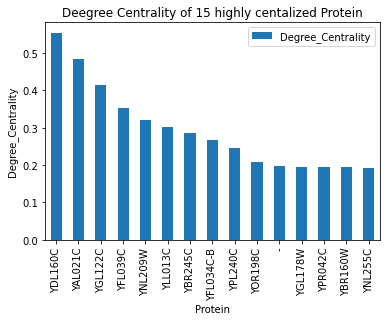

In [9]:
df_2.plot.bar(x="Protein", y="Degree_Centrality")
plt.xlabel("Protein") 
plt.ylabel("Degree_Centrality") 
plt.title("Deegree Centrality of 15 highly centalized Protein")
plt.show()

In [10]:
#CHECKING THE INDEX OF Node "-"

protien_node_list.index("-")

4898



1.   Node "-" is a missing value and must be deleted from the node graph network.
2.   It's index is 4898 in the variable adj.



# **Eigenvector centrality** 
Is a kind of extension of degree—it looks at a combination of a node’s edges and the edges of that node’s neighbors. If you know a lot of well-connected people, you could spread a message very efficiently.

In [0]:
eigenvector_dict = nx.eigenvector_centrality(g)
nx.set_node_attributes(g, eigenvector_dict, 'eigenvector')

In [0]:
sorted_eigenvector_centrality = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)


In [13]:
df_3 = pd.DataFrame (sorted_eigenvector_centrality,columns=['Protein','eigenvector_Centrality'])
df_4 = df_3.head(20)
df_4

,Protein,eigenvector_Centrality
0,YDL160C,0.106154
1,YAL021C,0.090872
2,YFL039C,0.088621
3,YGL122C,0.076512
4,YFL034C-B,0.069559
5,YNL209W,0.062700
6,YNR051C,0.058706
7,YLL013C,0.056590
8,YLR268W,0.055551
9,YBR160W,0.055058


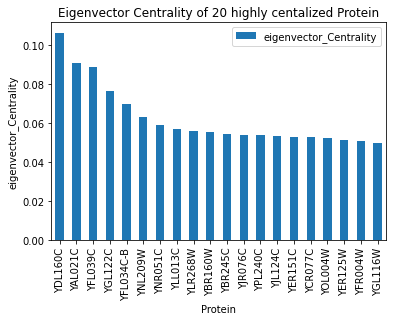

In [14]:
df_4.plot.bar(x="Protein", y="eigenvector_Centrality")
plt.xlabel("Protein") 
plt.ylabel("eigenvector_Centrality") 
plt.title("Eigenvector Centrality of 20 highly centalized Protein")
plt.show()

In [15]:
# Node "-" is connection count
print("Node '-' is connceted to :",len(g.edges("-")),"proteins")

Node '-' is connceted to : 1291 proteins


In [16]:
# Creating a list of index to retain in adj matrix

col_list = list(range(6526))
col_list.pop(4898)            # remove "-" node i.e. index 4898

protien_node_list.pop(4898)   # Also remove from names list

'-'

In [17]:
adj_copy = adj.copy()
adj_new = sparse.lil_matrix(sparse.csr_matrix(adj_copy)[:,col_list]) # DELETE FROM COLUMN
adj_new = sparse.lil_matrix(sparse.csr_matrix(adj_new)[col_list,:])  # DELETE FROM ROW
adj = adj_new
del adj_new, adj_copy
adj

# Edges remaining after deletion of 1291 edges from rows and columns respectively
# 1062675 - 1291 - 1291

<6525x6525 sparse matrix of type '<class 'numpy.longlong'>'
	with 1060093 stored elements in List of Lists format>

##### **Check if Adj is symmetrical**

In [18]:
# CHECKING if adj is symmetrical.
((adj.transpose() == adj).toarray()).all()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  


True

In [19]:
print("Index of protien YAL008W node          : ",protien_node_list.index("YAL008W"))  # find index of protien "YAL008W"
print("Index of protien YNR020C node          : ",protien_node_list.index("YNR020C"))  # find index of protien "YNR020C"
print("Conncetion between YAL008W and YNR020C : ",g.has_edge(protien_node_list[protien_node_list.index("YAL008W")], protien_node_list[protien_node_list.index("YNR020C")])) # Check if edge is present between two protien nodes


Index of protien YAL008W node          :  4538
Index of protien YNR020C node          :  4390
Conncetion between YAL008W and YNR020C :  True


In [20]:
# Check if matrix is directed or undirected. If directed, we will make it undirected matrix.
# As it the direction of edge does not matter i.e. if protien A is connceted to protien 
# B or protien B is connceted to protien A 

print("Value of cell at index location adj[0,1801] : ",adj[4538,4390])
print("Value of cell at index location adj[1801,0] : ",adj[4390,4538])

Value of cell at index location adj[0,1801] :  1
Value of cell at index location adj[1801,0] :  1


1.   Since adj is symmetrical, Let's consider Upper Triangle only for feature extraction.



In [0]:
# Function to build test set with 2% positive links
# Remove diagonal elements
adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj.eliminate_zeros()

In [22]:
adj

<6525x6525 sparse matrix of type '<class 'numpy.longlong'>'
	with 1058408 stored elements in Compressed Sparse Row format>

### **Data Split**

In [0]:
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

adj_norm = preprocess_graph(adj)

In [24]:
adj_norm

(array([[   0,    0],
        [   1,    0],
        [   2,    0],
        ...,
        [4582, 6524],
        [5311, 6524],
        [6524, 6524]], dtype=int32),
 array([0.00104275, 0.00240022, 0.00150889, ..., 0.03553345, 0.04536092,
        0.05555556]),
 (6525, 6525))